# test_lens_fundamental_plane

基于 `db_zBEAMS_PEMD_100000_s1_GDB_phot_err_ManySF_TL.csv` 的 lens fundamental-plane 探针：
- 输入使用 `zL_true`, `zS_true`, `tE_true`, `veldisp_true`，并将 `veldisp_true` 线性映射为 `Re_true`（0.5-2.8 arcsec）
- `gamma` 不作为观测量，仅由 parent population 抽样
- 运行 clean/noisy 两套 HMC，输出 divergence、trace、corner overlay

In [1]:
import os
os.environ.setdefault('HDF5_USE_FILE_LOCKING', 'FALSE')

from pathlib import Path
import sys

workdir = Path.cwd()
if (workdir / 'hmc_scripts').exists() is False:
    workdir = Path('/users/tianli/LensedUniverse')
os.chdir(workdir)
if str(workdir) not in sys.path:
    sys.path.insert(0, str(workdir))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, init_to_value
import arviz as az

from slcosmo import tool
from hmc_scripts.corner_utils import select_corner_vars, make_overlay_corner

USE_X64 = os.environ.get("SLCOSMO_USE_X64", "0").strip().lower() in {"1", "true", "yes", "y", "on"}
jax.config.update("jax_enable_x64", USE_X64)
if USE_X64:
    numpyro.enable_x64()
if any(d.platform == "gpu" for d in jax.devices()):
    numpyro.set_platform("gpu")
else:
    numpyro.set_platform("cpu")
print("Precision mode:", "FP64" if USE_X64 else "FP32")

SEED = 42
rng_np = np.random.default_rng(SEED)
np.random.seed(SEED)

TEST_MODE = False
RESULT_DIR = Path('/mnt/lustre/tianli/LensedUniverse_result')
RESULT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = Path('result')
FIG_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path(os.environ.get('SLCOSMO_DATA_DIR', str(workdir / 'data')))
DATA_CSV = DATA_DIR / 'db_zBEAMS_PEMD_100000_s1_GDB_phot_err_ManySF_TL.csv'

Precision mode: FP32


In [3]:
cosmo_true = {'Omegam': 0.32, 'Omegak': 0.0, 'w0': -1.0, 'wa': 0.0, 'h0': 70.0}
cosmo_prior = {
    'w0_up': 0.0, 'w0_low': -2.0,
    'wa_up': 2.0, 'wa_low': -2.0,
    'omegak_up': 1.0, 'omegak_low': -1.0,
    'h0_up': 80.0, 'h0_low': 60.0,
    'omegam_up': 0.5, 'omegam_low': 0.1,
}

Z_SEP_MIN = 0.2

LUT = np.load(DATA_DIR / 'velocity_disp_table.npy')
N1, N2, N3, N4 = LUT.shape
thetaE_grid = np.linspace(0.5, 3.0, N1)
gamma_grid = np.linspace(1.2, 2.8, N2)
Re_grid = np.linspace(0.15, 3.0, N3)
beta_grid = np.linspace(-0.5, 0.8, N4)
jampy_interp = tool.make_4d_interpolant(thetaE_grid, gamma_grid, Re_grid, beta_grid, LUT)

fp_df = pd.read_csv(DATA_CSV)
if TEST_MODE:
    n_use = 200
else:
    n_use = 50000
select_idx = rng_np.choice(fp_df.shape[0], size=min(n_use, fp_df.shape[0]), replace=False)
fp_df = fp_df.iloc[np.sort(select_idx)].reset_index(drop=True)
zl_fp = fp_df['zL_true'].to_numpy()
zs_fp = fp_df['zS_true'].to_numpy()
zL_sigma_fp = np.abs(fp_df['sigma_zL_obs'].to_numpy())
zS_sigma_fp = np.abs(fp_df['sigma_zS_obs'].to_numpy())
thetaE_true_fp = fp_df['tE_true'].to_numpy()
veldisp_true_catalog = fp_df['veldisp_true'].to_numpy()
vel_frac_err_template = fp_df['sigma_veldisp_obs'].to_numpy() / veldisp_true_catalog
vel_min = np.min(veldisp_true_catalog)
vel_max = np.max(veldisp_true_catalog)
re_fp = 0.5 + (veldisp_true_catalog - vel_min) * (2.8 - 0.5) / (vel_max - vel_min)

print(
    'Re_true from linear veldisp mapping:'
    f' vmin={vel_min:.3f}, vmax={vel_max:.3f}, min={re_fp.min():.4f}, median={np.median(re_fp):.4f}, max={re_fp.max():.4f}'
)
theta_keep_mask = thetaE_true_fp <= 2.5
print('After thetaE_true<=2.5 cut:', int(theta_keep_mask.sum()), '/', theta_keep_mask.size)
zl_fp = zl_fp[theta_keep_mask]
zs_fp = zs_fp[theta_keep_mask]
zL_sigma_fp = zL_sigma_fp[theta_keep_mask]
zS_sigma_fp = zS_sigma_fp[theta_keep_mask]
thetaE_true_fp = thetaE_true_fp[theta_keep_mask]
re_fp = re_fp[theta_keep_mask]
veldisp_true_catalog = veldisp_true_catalog[theta_keep_mask]
vel_frac_err_template = vel_frac_err_template[theta_keep_mask]
thetaE_err_fp = 0.01 * thetaE_true_fp

_dl_fp_true, ds_fp_true, dls_fp_true = tool.dldsdls(zl_fp, zs_fp, cosmo_true, n=20)
gamma_true_fp = tool.truncated_normal(2.0, 0.2, 1.5, 2.5, zl_fp.size, random_state=rng_np)
beta_true_fp = tool.truncated_normal(0.0, 0.2, -0.4, 0.4, zl_fp.size, random_state=rng_np)
lambda_true_fp = tool.truncated_normal(1.0, 0.05, 0.8, 1.2, zl_fp.size, random_state=rng_np)
vel_model_fp = jampy_interp(thetaE_true_fp, gamma_true_fp, re_fp, beta_true_fp) * jnp.sqrt(ds_fp_true / dls_fp_true)
vel_true_fp = np.asarray(vel_model_fp) * np.sqrt(lambda_true_fp)
vel_err_fp = vel_frac_err_template * np.abs(vel_true_fp)

clean_keep_mask = vel_true_fp <= 400.0
print('After clean vel<=400 cut:', int(clean_keep_mask.sum()), '/', clean_keep_mask.size)
zl_fp = zl_fp[clean_keep_mask]
zs_fp = zs_fp[clean_keep_mask]
zL_sigma_fp = zL_sigma_fp[clean_keep_mask]
zS_sigma_fp = zS_sigma_fp[clean_keep_mask]
thetaE_true_fp = thetaE_true_fp[clean_keep_mask]
thetaE_err_fp = thetaE_err_fp[clean_keep_mask]
re_fp = re_fp[clean_keep_mask]
gamma_true_fp = gamma_true_fp[clean_keep_mask]
beta_true_fp = beta_true_fp[clean_keep_mask]
lambda_true_fp = lambda_true_fp[clean_keep_mask]
vel_true_fp = vel_true_fp[clean_keep_mask]
vel_err_fp = vel_err_fp[clean_keep_mask]

thetaE_obs_clean_fp = thetaE_true_fp.copy()
vel_obs_clean_fp = vel_true_fp.copy()
vel_q = np.quantile(vel_obs_clean_fp, [0.01, 0.05, 0.50, 0.95, 0.99])
print(
    'vel_obs_clean_fp stats before noisy cuts:'
    f' min={vel_obs_clean_fp.min():.3f}, q01={vel_q[0]:.3f}, q05={vel_q[1]:.3f},'
    f' median={vel_q[2]:.3f}, q95={vel_q[3]:.3f}, q99={vel_q[4]:.3f}, max={vel_obs_clean_fp.max():.3f}'
)

thetaE_obs_noisy_fp = thetaE_true_fp + rng_np.normal(0.0, thetaE_err_fp)
vel_obs_noisy_fp = tool.truncated_normal(vel_true_fp, vel_err_fp, 100.0, 500.0, random_state=rng_np)
noisy_keep_mask = vel_obs_noisy_fp <= 400.0
print('After noisy vel<=400 cut:', int(noisy_keep_mask.sum()), '/', noisy_keep_mask.size)

zl_fp = zl_fp[noisy_keep_mask]
zs_fp = zs_fp[noisy_keep_mask]
zL_sigma_fp = zL_sigma_fp[noisy_keep_mask]
zS_sigma_fp = zS_sigma_fp[noisy_keep_mask]
thetaE_true_fp = thetaE_true_fp[noisy_keep_mask]
thetaE_err_fp = thetaE_err_fp[noisy_keep_mask]
re_fp = re_fp[noisy_keep_mask]
gamma_true_fp = gamma_true_fp[noisy_keep_mask]
beta_true_fp = beta_true_fp[noisy_keep_mask]
lambda_true_fp = lambda_true_fp[noisy_keep_mask]
vel_err_fp = vel_err_fp[noisy_keep_mask]
thetaE_obs_clean_fp = thetaE_obs_clean_fp[noisy_keep_mask]
vel_obs_clean_fp = vel_obs_clean_fp[noisy_keep_mask]
thetaE_obs_noisy_fp = thetaE_obs_noisy_fp[noisy_keep_mask]
vel_obs_noisy_fp = vel_obs_noisy_fp[noisy_keep_mask]

z_true_mask = (zl_fp > 0.0) & (zs_fp > zl_fp + Z_SEP_MIN)
print(f'After true-z cut (zs-zl>{Z_SEP_MIN:.1f}):', int(z_true_mask.sum()), '/', z_true_mask.size)
zl_fp = zl_fp[z_true_mask]
zs_fp = zs_fp[z_true_mask]
zL_sigma_fp = zL_sigma_fp[z_true_mask]
zS_sigma_fp = zS_sigma_fp[z_true_mask]
thetaE_true_fp = thetaE_true_fp[z_true_mask]
thetaE_err_fp = thetaE_err_fp[z_true_mask]
re_fp = re_fp[z_true_mask]
gamma_true_fp = gamma_true_fp[z_true_mask]
beta_true_fp = beta_true_fp[z_true_mask]
lambda_true_fp = lambda_true_fp[z_true_mask]
vel_err_fp = vel_err_fp[z_true_mask]
thetaE_obs_clean_fp = thetaE_obs_clean_fp[z_true_mask]
vel_obs_clean_fp = vel_obs_clean_fp[z_true_mask]
thetaE_obs_noisy_fp = thetaE_obs_noisy_fp[z_true_mask]
vel_obs_noisy_fp = vel_obs_noisy_fp[z_true_mask]

zl_obs_clean_fp = zl_fp.copy()
zs_obs_clean_fp = zs_fp.copy()
zl_obs_noisy_fp = zl_fp + rng_np.normal(0.0, zL_sigma_fp)
zs_obs_noisy_fp = zs_fp + rng_np.normal(0.0, zS_sigma_fp)
bad_z_mask = (zl_obs_noisy_fp <= 0.0) | (zs_obs_noisy_fp <= 0.0) | (zs_obs_noisy_fp <= zl_obs_noisy_fp + Z_SEP_MIN)
for _ in range(20):
    if not np.any(bad_z_mask):
        break
    zl_obs_noisy_fp[bad_z_mask] = zl_fp[bad_z_mask] + rng_np.normal(0.0, zL_sigma_fp[bad_z_mask])
    zs_obs_noisy_fp[bad_z_mask] = zs_fp[bad_z_mask] + rng_np.normal(0.0, zS_sigma_fp[bad_z_mask])
    bad_z_mask = (zl_obs_noisy_fp <= 0.0) | (zs_obs_noisy_fp <= 0.0) | (zs_obs_noisy_fp <= zl_obs_noisy_fp + Z_SEP_MIN)
zl_obs_noisy_fp = np.maximum(zl_obs_noisy_fp, 1e-4)
zs_obs_noisy_fp = np.maximum(zs_obs_noisy_fp, zl_obs_noisy_fp + Z_SEP_MIN + 1e-4)
print(
    'Noisy z constraints applied:',
    f' zl_min={zl_obs_noisy_fp.min():.4f}, zs_min={zs_obs_noisy_fp.min():.4f},'
    f' min(zs-zl)={(zs_obs_noisy_fp - zl_obs_noisy_fp).min():.4e}'
)

gamma_err_fp = np.full(zl_fp.size, 0.2)
n_gamma_obs = min(10000, zl_fp.size)
gamma_has_obs = np.zeros(zl_fp.size, dtype=bool)
gamma_obs_idx = rng_np.choice(zl_fp.size, size=n_gamma_obs, replace=False)
gamma_has_obs[gamma_obs_idx] = True

gamma_obs_clean_fp = np.zeros(zl_fp.size)
gamma_obs_clean_fp[gamma_has_obs] = gamma_true_fp[gamma_has_obs]
gamma_obs_noisy_fp = np.zeros(zl_fp.size)
gamma_obs_noisy_fp[gamma_has_obs] = gamma_true_fp[gamma_has_obs] + rng_np.normal(0.0, gamma_err_fp[gamma_has_obs])

def build_data(zl_obs, zs_obs, theta_E_obs, vel_obs, gamma_obs):
    return {
        'zl': zl_obs,
        'zs': zs_obs,
        'zl_true': zl_fp,
        'zs_true': zs_fp,
        'zL_err': zL_sigma_fp,
        'zS_err': zS_sigma_fp,
        'theta_E': theta_E_obs,
        'theta_E_true': thetaE_true_fp,
        'theta_E_err': thetaE_err_fp,
        're': re_fp,
        'vel_obs': vel_obs,
        'vel_err': vel_err_fp,
        'gamma_obs': gamma_obs,
        'gamma_true': gamma_true_fp,
        'gamma_err': gamma_err_fp,
        'gamma_has_obs': gamma_has_obs,
        'beta_true': beta_true_fp,
        'lambda_true': lambda_true_fp,
    }

fp_data_clean = build_data(zl_obs_clean_fp, zs_obs_clean_fp, thetaE_obs_clean_fp, vel_obs_clean_fp, gamma_obs_clean_fp)
fp_data_noisy = build_data(zl_obs_noisy_fp, zs_obs_noisy_fp, thetaE_obs_noisy_fp, vel_obs_noisy_fp, gamma_obs_noisy_fp)
print('N_lens =', zl_fp.shape[0], 'N_gamma_obs =', int(gamma_has_obs.sum()))


Re_true from linear veldisp mapping: vmin=163.881, vmax=464.324, min=0.5000, median=1.4143, max=2.8000
After thetaE_true<=2.5 cut: 48762 / 50000
After clean vel<=400 cut: 48712 / 48762
vel_obs_clean_fp stats before noisy cuts: min=125.335, q01=161.017, q05=179.755, median=239.405, q95=321.393, q99=359.400, max=399.948
After noisy vel<=400 cut: 46648 / 48712
After true-z physical cut: 46648 / 46648
Noisy z constraints applied:  zl_min=0.0006, zs_min=0.1657, min(zs-zl)=1.8365e-02
N_lens = 46648 N_gamma_obs = 10000


In [ ]:
# Corner plot after data preparation
import corner

samples_fp = np.column_stack([
    thetaE_obs_clean_fp,
    re_fp,
    zs_obs_clean_fp,
    zl_obs_clean_fp,
    vel_obs_clean_fp,
])

labels_fp = [
    r'$\theta_E$ (arcsec)',
    r'$R_e$ (arcsec)',
    r'$z_s$',
    r'$z_l$',
    r'$\sigma_v$ (km/s)',
]

fig = corner.corner(
    samples_fp,
    labels=labels_fp,
    bins=40,
    show_titles=True,
    title_fmt='.3f',
    quantiles=[0.16, 0.5, 0.84],
)
fig.savefig(FIG_DIR / 'lens_fp_data_corner.pdf', dpi=200, bbox_inches='tight')
plt.show()
print('Saved:', FIG_DIR / 'lens_fp_data_corner.pdf')


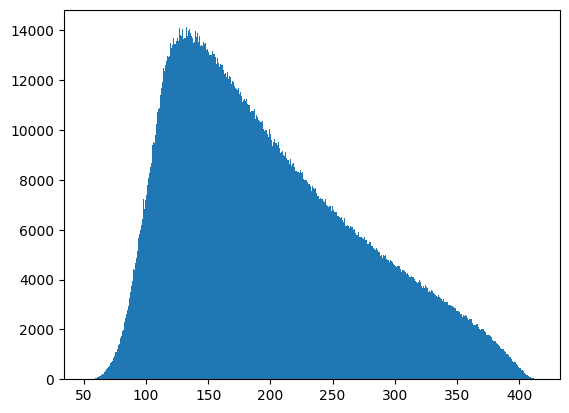

In [4]:
_ = plt.hist(LUT.flatten(), bins = 1000)

(array([5.700e+01, 7.330e+02, 2.644e+03, 4.611e+03, 5.689e+03, 5.747e+03,
        4.811e+03, 4.130e+03, 3.483e+03, 2.751e+03, 2.194e+03, 1.803e+03,
        1.496e+03, 1.265e+03, 1.019e+03, 8.790e+02, 7.330e+02, 5.800e+02,
        5.250e+02, 4.340e+02, 3.710e+02, 3.280e+02, 2.820e+02, 2.780e+02,
        2.260e+02, 2.120e+02, 1.800e+02, 1.650e+02, 1.430e+02, 1.240e+02,
        1.020e+02, 9.300e+01, 1.130e+02, 8.200e+01, 8.100e+01, 7.500e+01,
        6.900e+01, 6.500e+01, 4.600e+01, 4.000e+01, 2.900e+01, 2.100e+01,
        1.600e+01, 1.400e+01, 9.000e+00, 7.000e+00, 5.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.16254459, 0.1785511 , 0.19455762, 0.21056414, 0.22657066,
        0.24257718, 0.2585837 , 0.27459022, 0.29059673, 0.30660325,
        0.32260977, 0.33861629, 0.35462281, 0.37062933, 0.38663585,
        0.40264236, 0.41864888, 0.4346554 , 0.45066192, 0.46666844,
        0.48267496, 0.49868147, 0.51468799, 0.53069451, 0.54670103,
        0.56270755, 0.57871407, 0.59

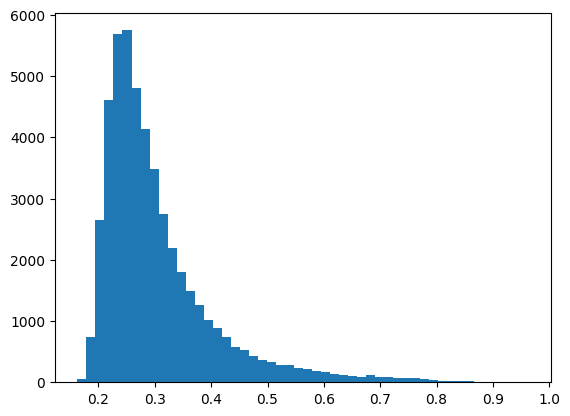

In [5]:
plt.hist(vel_frac_err_template, bins = 50)
# plt.xlim([1.5, 2.5])
# plt.ylim([0, 1000])

In [6]:
def cosmology_model(kind, cosmo_prior, sample_h0=True):
    cosmo = {
        'Omegam': numpyro.sample('Omegam', dist.Uniform(cosmo_prior['omegam_low'], cosmo_prior['omegam_up'])),
        'Omegak': 0.0,
        'w0': -1.0,
        'wa': 0.0,
        'h0': 70.0,
    }
    if kind in ['wcdm', 'owcdm', 'waw0cdm', 'owaw0cdm']:
        cosmo['w0'] = numpyro.sample('w0', dist.Uniform(cosmo_prior['w0_low'], cosmo_prior['w0_up']))
    if kind in ['waw0cdm', 'owaw0cdm']:
        cosmo['wa'] = numpyro.sample('wa', dist.Uniform(cosmo_prior['wa_low'], cosmo_prior['wa_up']))
    if kind in ['owcdm', 'owaw0cdm']:
        cosmo['Omegak'] = numpyro.sample('Omegak', dist.Uniform(cosmo_prior['omegak_low'], cosmo_prior['omegak_up']))
    if sample_h0:
        cosmo['h0'] = numpyro.sample('h0', dist.Uniform(cosmo_prior['h0_low'], cosmo_prior['h0_up']))
    return cosmo


def fundamental_plane_model(fp_data):
    cosmo = cosmology_model('waw0cdm', cosmo_prior, sample_h0=True)

    lambda_mean = numpyro.sample('lambda_mean', dist.Uniform(0.9, 1.1))
    lambda_sigma = numpyro.sample('lambda_sigma', dist.TruncatedNormal(0.05, 0.5, low=0.0, high=0.2))
    gamma_mean = numpyro.sample('gamma_mean', dist.Uniform(1.4, 2.6))
    gamma_sigma = numpyro.sample('gamma_sigma', dist.TruncatedNormal(0.2, 0.2, low=0.0, high=0.4))
    beta_mean = numpyro.sample('beta_mean', dist.Uniform(-0.3, 0.3))
    beta_sigma = numpyro.sample('beta_sigma', dist.TruncatedNormal(0.2, 0.2, low=0.0, high=0.4))

    n_lens = len(fp_data['zl'])
    with numpyro.plate('fp_redshift', n_lens):
        zL_fp = numpyro.sample(
            'zL_fp_latent',
            dist.TruncatedNormal(fp_data['zl'], fp_data['zL_err'], low=1e-4),
        )
        zS_fp = numpyro.sample(
            'zS_fp_latent',
            dist.TruncatedNormal(fp_data['zs'], fp_data['zS_err'], low=zL_fp + Z_SEP_MIN),
        )

    _dl, ds_fp, dls_fp = tool.dldsdls(zL_fp, zS_fp, cosmo, n=20)
    with numpyro.plate('fundamental_plane', n_lens):
        gamma_fp = numpyro.sample('gamma_fp', dist.TruncatedNormal(gamma_mean, gamma_sigma, low=1.4, high=2.6))
        beta_fp = numpyro.sample('beta_fp', dist.TruncatedNormal(beta_mean, beta_sigma, low=-0.4, high=0.4))
        lambda_fp = numpyro.sample('lambda_fp', dist.TruncatedNormal(lambda_mean, lambda_sigma, low=0.8, high=1.2))
        thetaE_fp = numpyro.sample('thetaE_fp', dist.Normal(fp_data['theta_E'], fp_data['theta_E_err']))

        v_interp_fp = jampy_interp(thetaE_fp, gamma_fp, fp_data['re'], beta_fp)
        vel_pred_fp = v_interp_fp * jnp.sqrt(ds_fp / dls_fp) * jnp.sqrt(lambda_fp)
        gamma_obs_mask = jnp.asarray(fp_data['gamma_has_obs'])
        gamma_obs_used = jnp.where(gamma_obs_mask, fp_data['gamma_obs'], gamma_fp)
        numpyro.sample(
            'gamma_fp_like',
            dist.Normal(gamma_fp, fp_data['gamma_err']).mask(gamma_obs_mask),
            obs=gamma_obs_used,
        )
        numpyro.sample(
            'vel_fp_like',
            dist.Normal(vel_pred_fp, fp_data['vel_err']),
            obs=fp_data['vel_obs'],
        )

In [7]:
def build_init_values(fp_data):
    zl_true = np.asarray(fp_data.get('zl_true', fp_data['zl']), dtype=np.float64)
    zs_true = np.asarray(fp_data.get('zs_true', fp_data['zs']), dtype=np.float64)
    theta_true = np.asarray(fp_data.get('theta_E_true', fp_data['theta_E']), dtype=np.float64)
    gamma_true = np.asarray(fp_data.get('gamma_true', fp_data['gamma_obs']), dtype=np.float64)
    beta_true = np.asarray(fp_data.get('beta_true', np.zeros_like(theta_true)), dtype=np.float64)
    lambda_true = np.asarray(fp_data.get('lambda_true', np.ones_like(theta_true)), dtype=np.float64)

    zl_true = np.maximum(zl_true, 1e-3)
    zs_true = np.maximum(zs_true, zl_true + Z_SEP_MIN + 1e-3)
    theta_true = np.maximum(theta_true, 1e-3)
    gamma_true = np.clip(gamma_true, 1.401, 2.599)
    beta_true = np.clip(beta_true, -0.399, 0.399)
    lambda_true = np.clip(lambda_true, 0.801, 1.199)

    return {
        'Omegam': jnp.asarray(cosmo_true['Omegam']),
        'w0': jnp.asarray(cosmo_true['w0']),
        'wa': jnp.asarray(cosmo_true['wa']),
        'h0': jnp.asarray(cosmo_true['h0']),
        'lambda_mean': jnp.asarray(1.0),
        'lambda_sigma': jnp.asarray(0.08),
        'gamma_mean': jnp.asarray(2.0),
        'gamma_sigma': jnp.asarray(0.25),
        'beta_mean': jnp.asarray(0.0),
        'beta_sigma': jnp.asarray(0.25),
        'zL_fp_latent': jnp.asarray(zl_true),
        'zS_fp_latent': jnp.asarray(zs_true),
        'gamma_fp': jnp.asarray(gamma_true),
        'beta_fp': jnp.asarray(beta_true),
        'lambda_fp': jnp.asarray(lambda_true),
        'thetaE_fp': jnp.asarray(theta_true),
    }


def run_mcmc(data, key, tag):
    if TEST_MODE:
        num_warmup, num_samples, num_chains, chain_method = 200, 200, 2, 'sequential'
    else:
        num_warmup, num_samples, num_chains, chain_method = 500, 1500, 4, 'vectorized'

    nuts = NUTS(
        fundamental_plane_model,
        target_accept_prob=0.95,
        init_strategy=init_to_value(values=build_init_values(data)),
    )
    mcmc = MCMC(
        nuts,
        num_warmup=num_warmup,
        num_samples=num_samples,
        num_chains=num_chains,
        chain_method=chain_method,
        progress_bar=True,
    )
    mcmc.run(key, fp_data=data)
    print(f'[{tag}] run uses init_to_value')

    extra = mcmc.get_extra_fields(group_by_chain=True)
    n_div = int(np.asarray(extra['diverging']).sum())
    print(f'[{tag}] divergences: {n_div}')

    posterior = mcmc.get_samples(group_by_chain=True)
    inf_data = az.from_dict(posterior=posterior)
    az.to_netcdf(inf_data, RESULT_DIR / f'lens_fp_{tag}.nc')

    trace_vars = ['h0', 'Omegam', 'w0', 'wa', 'lambda_mean', 'lambda_sigma', 'gamma_mean', 'gamma_sigma', 'beta_mean', 'beta_sigma']
    trace_vars = [v for v in trace_vars if v in inf_data.posterior and inf_data.posterior[v].ndim == 2]
    if trace_vars:
        trace_axes = az.plot_trace(inf_data, var_names=trace_vars, compact=False)
        trace_fig = np.asarray(trace_axes).ravel()[0].figure
        trace_fig.savefig(FIG_DIR / f'lens_fp_trace_{tag}.pdf', dpi=200, bbox_inches='tight')
        plt.close(trace_fig)
    return inf_data


key = random.PRNGKey(42)
key_clean, key_noisy = random.split(key)

idata_clean = run_mcmc(fp_data_clean, key_clean, 'clean')
idata_noisy = run_mcmc(fp_data_noisy, key_noisy, 'noisy')


sample: 100%|██████████| 2000/2000 [24:51<00:00,  1.34it/s]


[clean] run uses init_to_value
[clean] divergences: 0


sample: 100%|██████████| 2000/2000 [11:22<00:00,  2.93it/s]


[noisy] run uses init_to_value
[noisy] divergences: 0


In [8]:
corner_vars = select_corner_vars(
    idata_clean,
    idata_noisy,
    ['h0', 'Omegam', 'w0', 'wa', 'lambda_mean', 'lambda_sigma', 'gamma_mean', 'gamma_sigma', 'beta_mean', 'beta_sigma'],
)
make_overlay_corner(idata_clean, idata_noisy, corner_vars, FIG_DIR / 'lens_fp_corner_overlay.pdf')

print('Saved:')
print(RESULT_DIR / 'lens_fp_clean.nc')
print(RESULT_DIR / 'lens_fp_noisy.nc')
print(FIG_DIR / 'lens_fp_trace_clean.pdf')
print(FIG_DIR / 'lens_fp_trace_noisy.pdf')
print(FIG_DIR / 'lens_fp_corner_overlay.pdf')

Saved:
/mnt/lustre/tianli/LensedUniverse_result/lens_fp_clean.nc
/mnt/lustre/tianli/LensedUniverse_result/lens_fp_noisy.nc
result/lens_fp_trace_clean.pdf
result/lens_fp_trace_noisy.pdf
result/lens_fp_corner_overlay.pdf


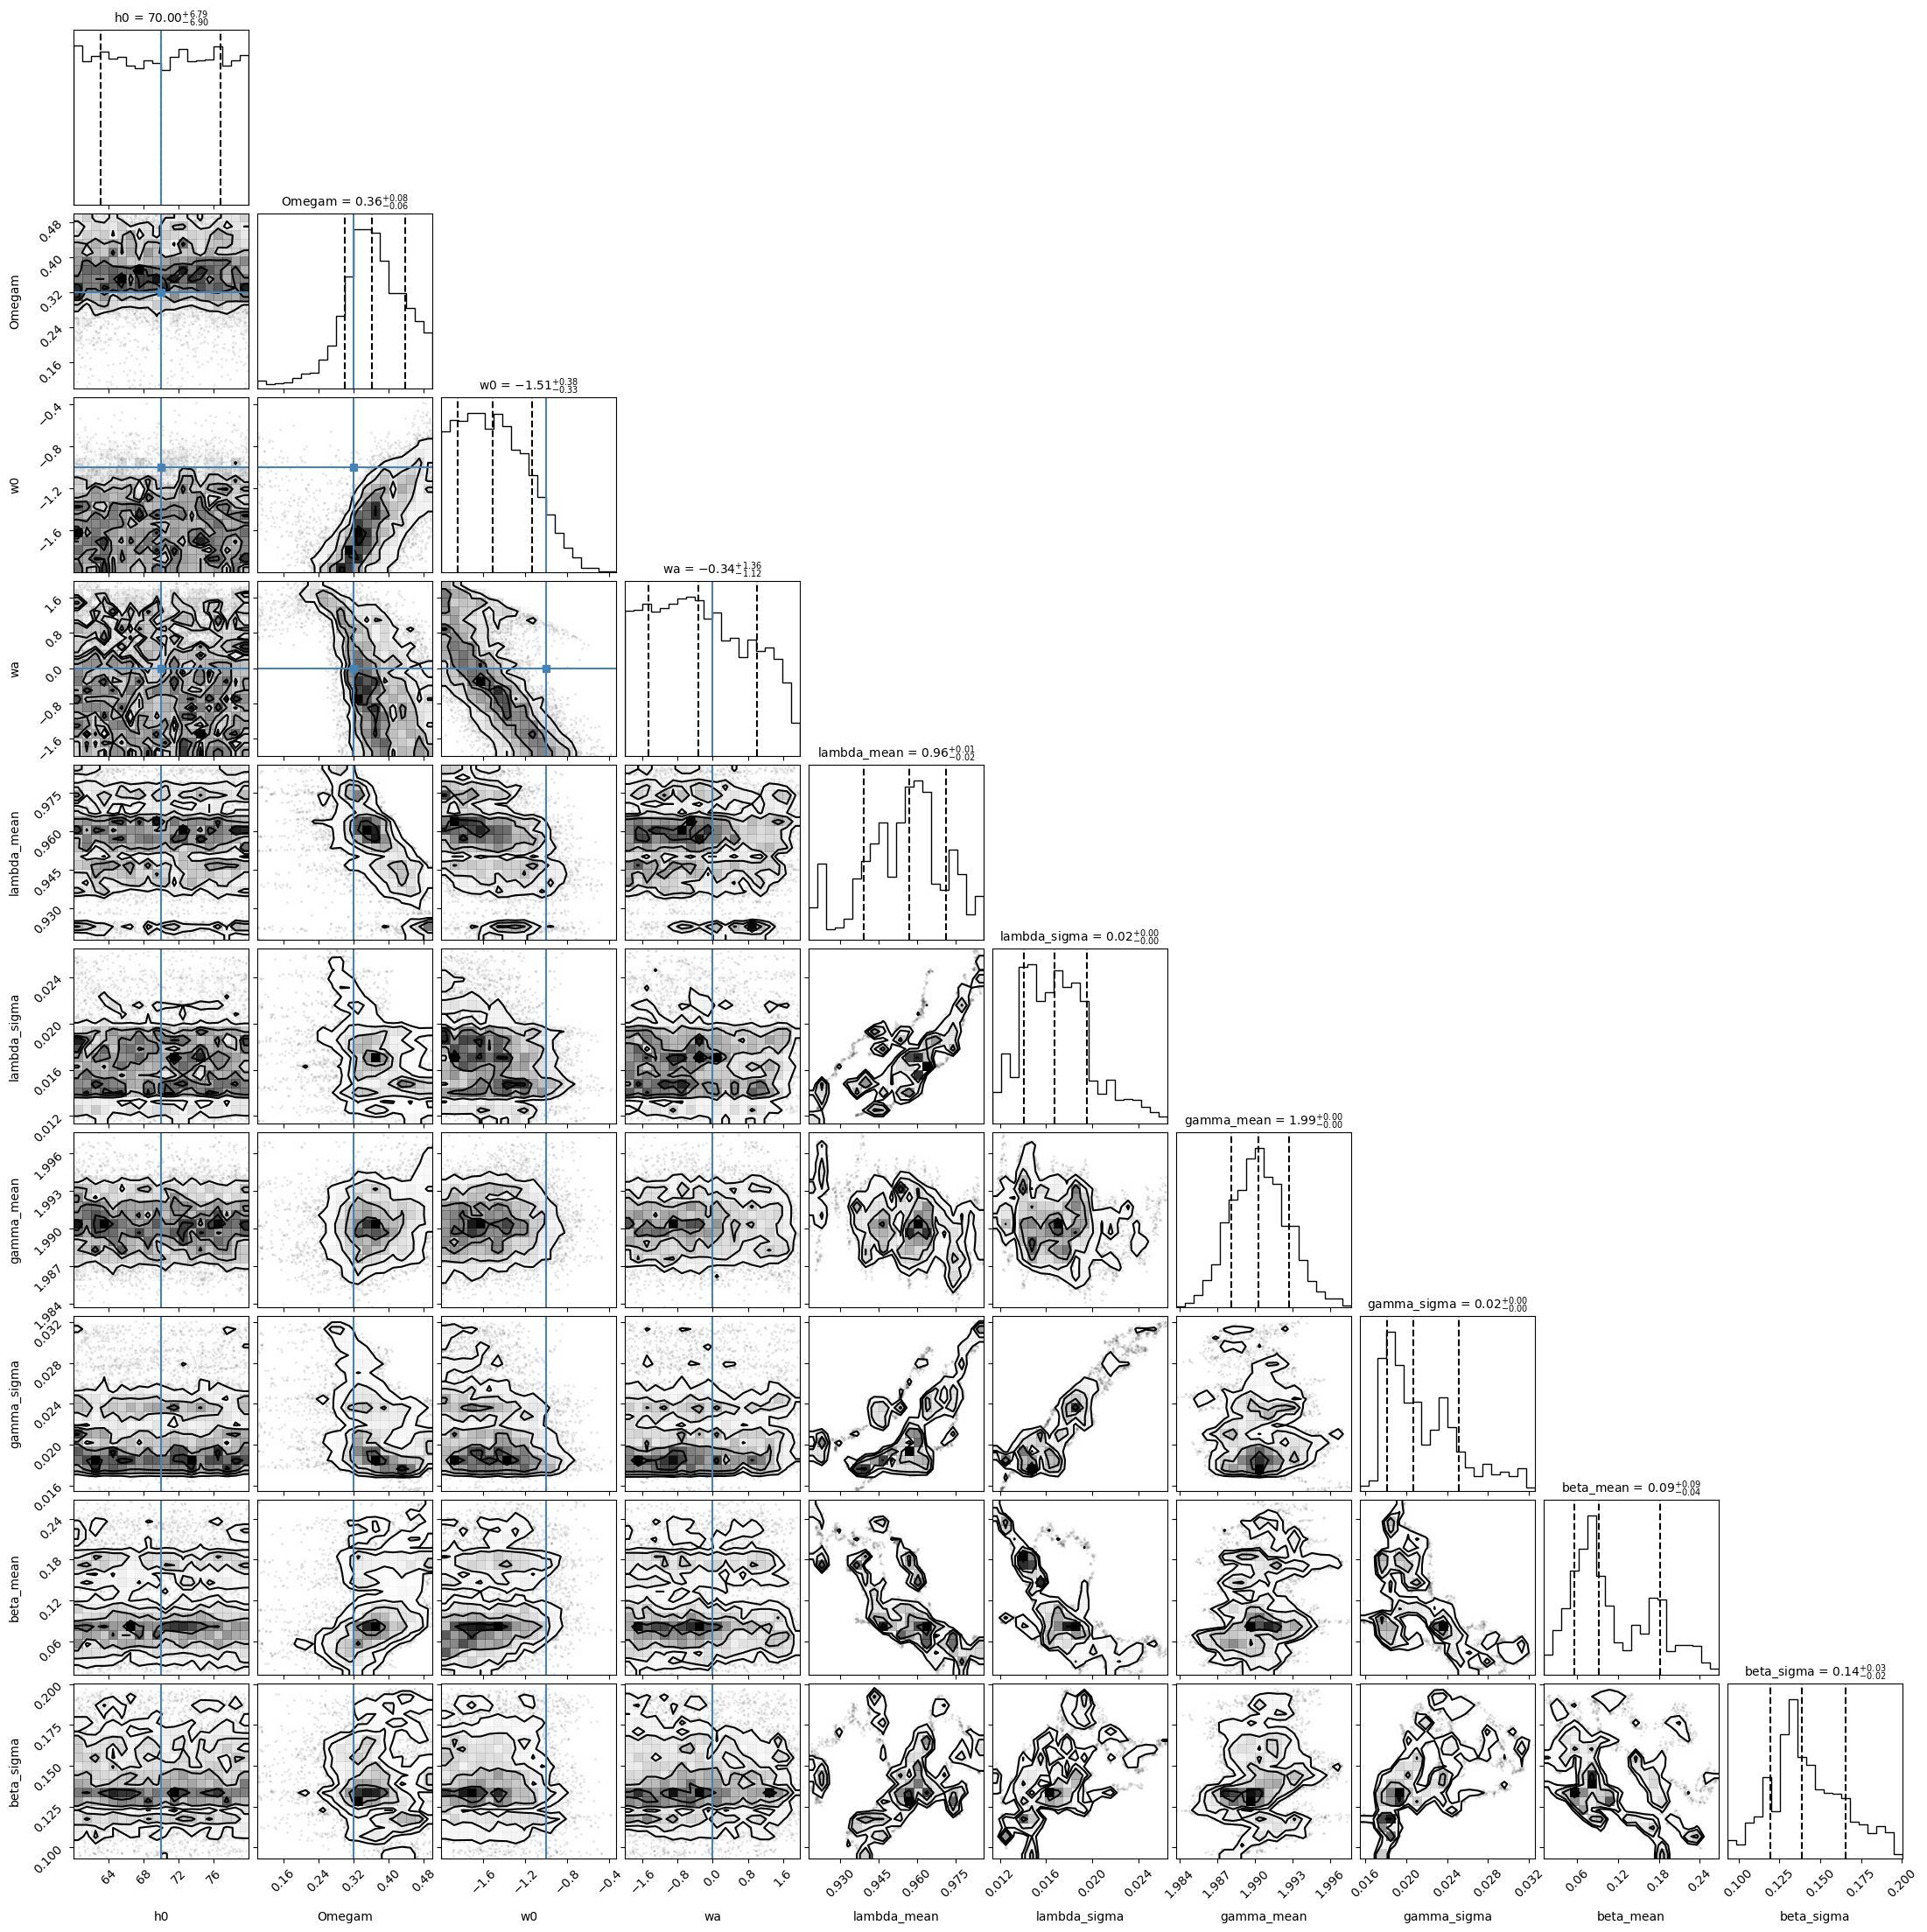

In [9]:
import arviz as az
import numpy as np
import corner
import matplotlib.pyplot as plt

path = "/mnt/lustre/tianli/LensedUniverse_result/lens_fp_clean.nc"
idata = az.from_netcdf(path)

vars_ = ['h0', 'Omegam', 'w0', 'wa',
         'lambda_mean', 'lambda_sigma',
         'gamma_mean', 'gamma_sigma',
         'beta_mean', 'beta_sigma']

post = idata.posterior
missing = [v for v in vars_ if v not in post.data_vars]
if missing:
    raise KeyError(f"Missing in idata.posterior: {missing}\nAvailable: {list(post.data_vars)}")

# --- truths: fill these with your ground-truth / injected values ---
truth_dict = {
    'h0': 70, 'Omegam': 0.32, 'w0': -1, 'wa': 0,
    'lambda_mean': 1, 'lambda_sigma': 0.05,
    'gamma_mean': 2, 'gamma_sigma': 0.2,
    'beta_mean': 0, 'beta_sigma': 0.5,
}
truths = [truth_dict[v] for v in vars_]  # order must match vars_

# stack chains/draws -> (nsamples, nvars)
samples = np.column_stack([
    np.asarray(post[v].stack(sample=("chain", "draw")).values).reshape(-1)
    for v in vars_
])

fig = corner.corner(
    samples,
    labels=vars_,
    truths=truths,                 # <- adds truth lines/markers
    show_titles=True,
    title_kwargs={"fontsize": 10},
    quantiles=[0.16, 0.5, 0.84],
)
plt.show()
